## **Summary of class/functions for calculating DRR and tracking cell movements**.


* ***to do: merge the function for the from flexed side and from the extended side for the collecting data.***

* ***make the data folder for the DRR_cell_movements***


> * initial part based on: 20201117_WithNewMergedLabel_Plot_tibia_angle_with_DRR_cell_movements_73D10_all.ipynb


> * Summarizing multiple trials based on:
20210311_Summarize4_3_tibia_angle_DRR_cell_movements_JR476Combined.ipynb
and 73D10 version of it.

> * Further summary based on:
20210311_Summary5_2_tibia_angle_DRR_cell_movements_CombinedJR476_withRotation_withTimeAxis.ipynb
 and 73D10 version of it.



### Connect to the google drive

In [1]:
#link to the google drive. Need to follow the authorization instructions.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the necessary packages.
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
import pickle
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops_table
import cv2
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sb



'''
### A function for calculating the weighted centroid of each cell for every frame using all pixels, and calculating the GCaMP/tdTomato ratio for each cell for each frame.

- #### Use the labels and tdTomato signal to calculate the weighted centroids for each frame.

- #### Use the labels and tdTomato and GCaMP signal to calculate the GCaMP/TdTomato ratio

- #### Return the row and column values for the weighted centroids and GCaMP_tdTomato_ratio

'''
def get_weighted_centroid_GCamp_tdTomato_ratio(labels_data, GCaMP_data, tdTomato_data):
    
    #need to know how many clusters we have.labels also have 0 for background so we will have a column for that as well
    cluster_number = len(np.unique(labels_data))-1
    
    #Also need to know the actual labels (sometime they are skipped)
    cluster_id=np.unique(labels_data)
    
    #Number of frames in the data
    total_frames = labels_data.shape[0]

    #initialize some data array
    GCaMP_tdTomato=np.zeros((total_frames,cluster_number))
    centroid_row_values=np.zeros((total_frames,cluster_number))
    centroid_column_values = np.zeros((total_frames, cluster_number))

    #Go through all the frames.
    for frame_number in range(total_frames):
        #
        #Get the weighted centroid and place them in the data array
        props_table = regionprops_table(labels_data[frame_number,:,:], tdTomato_data[frame_number, :, :], properties=['weighted_centroid'])
        centroid_row_values[frame_number,:]=props_table['weighted_centroid-0']
        centroid_column_values[frame_number,:]=props_table['weighted_centroid-1']

        #Get the GCaMP and tdTomato data for the frame
        GCaMP=GCaMP_data[frame_number,:,:]
        tdTomato=tdTomato_data[frame_number,:,:]
        
        #Get the GCaMP to tdTomato ratio for all the clusters    
        for cluster_index in range(cluster_number):
            #label has 0 for the background that we need to skip
            GCaMP_cluster=GCaMP[labels_data[frame_number,:,:]==cluster_id[cluster_index+1]]
            tdTomato_cluster=tdTomato[labels_data[frame_number,:,:]==cluster_id[cluster_index+1]]
            GCaMP_tdTomato[frame_number,cluster_index]=(np.mean(GCaMP_cluster))/(np.mean(tdTomato_cluster))

    return {'centroid_row':centroid_row_values, 'centroid_column':centroid_column_values, 'GCaMP_over_tdTomato':GCaMP_tdTomato}


'''
### A revised function for calculating DR/R, now look for the lowest R during the trial (average R over specified number of frames) and use that as the baseline.

### A function for calculating the DR/R based on the GCaMP_over_tdTomato ratio and the specified baseline.


*   GCaMP_tdTomato: Ratio of the GCaMP and tdTomato fluorescence for each tracked cell for all frames.
*   baseline_begin: a frame to use for the beginning of the baseline fluorescence calculation.
*baseline_end: a frame to use for the end of the baseline fluorescence calculation
'''
def calculate_DRR(GCaMP_tdTomato, baseline_length):
  #Find how many cells we have
  n_of_cells=GCaMP_tdTomato.shape[1]
  #Initialize the np.array for the baseline
  baseline=np.zeros((1,n_of_cells))


  #Calculate the "baseline_length average" over the entire trial for each cell.
  #Find the minimum value and define that as the baseline
  for cell in range(n_of_cells):
    #convolve with a window with baseline_length
    windowed_GCaMP_tdTomato=np.convolve(GCaMP_tdTomato[:,cell],np.ones((baseline_length,))/baseline_length, mode='valid')
    #find the minimu value and set that as the baseline.
    baseline[0,cell]=np.nanmin(windowed_GCaMP_tdTomato)

  #Subtract the baseline from the GCaMP/tdTomato ratio
  GCaMP_tdTomato_subbaseline=GCaMP_tdTomato-baseline
  #Calculate the change in the ratio relative to the baseline ratio
  DR_R=GCaMP_tdTomato_subbaseline/baseline

  return DR_R


'''
### Revised to use the new baseline definition (minimum during the entire trial)

### Revised to subtract the minimum value of the first frame from the entire stack for both the tdTomato and GCaMP signal.

### Revise to use the merged label and already converted angles.

### Make it into a function and run for all the trials for this fly.



*   Read in tdTomato signal, GCaMP signal, tibia angle, all-labels
*   convert tibia angle, calculate weighted centroid, calculate DR/R
* plot tibia angle with DR/R
* plot centroid movements
'''
def calculate_tibia_angle_DRR_centroid(trial_number, angles_file_path_sorted, merged_labels_files_path_sorted, tdTomato_files_path_sorted, GCaMP_files_path_sorted, baseline_length):
  #

  #get the femur-tibia angle.
  with open(angles_file_path_sorted[trial_number], "rb") as f:
    [image_femur_tibia_angle] = pickle.load(f)

  #get the new labels calculated from the front side.
  with open(merged_labels_files_path_sorted[trial_number], "rb") as f:
    merged_labels = pickle.load(f)

  #Get TdTomato signal
  with open(tdTomato_files_path_sorted[trial_number],"rb") as f:
    tdTomato_Filtered = pickle.load(f)
  tdTomato_min=np.nanmin(tdTomato_Filtered[0,:,:])
  tdTomato_Filtered=tdTomato_Filtered-tdTomato_min

  #Get GCaMP signal
  with open(GCaMP_files_path_sorted[trial_number],"rb") as f:
    GCaMP_Filtered=pickle.load(f)
  GCaMP_min=np.nanmin(GCaMP_Filtered[0,:,:])
  GCaMP_Filtered=GCaMP_Filtered-GCaMP_min


  #get the weighted centroid values and GCaMP-tdTomato ratio for the merged labels
  result_values1=get_weighted_centroid_GCamp_tdTomato_ratio(merged_labels, GCaMP_Filtered, tdTomato_Filtered)
  centroid_row_values1=result_values1['centroid_row']
  centroid_column_values1=result_values1['centroid_column']
  GCaMP_tdTomato1=result_values1['GCaMP_over_tdTomato']

  #Calculate DR/R based on first 15 frames as baseline (may change later: espcially for claw neurons that could be activated at beginning)
  DR_R=calculate_DRR(GCaMP_tdTomato1, baseline_length)

  #Angles are already unwrapped and converted to degrees.
  angle_deg = image_femur_tibia_angle

  #Plot the tibia angle at the top and then DR_R at the bottom (for all clusters)
  fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
  ax[0].plot(angle_deg)
  ax[1].plot(DR_R)

  number_of_cells=centroid_row_values1.shape[1]
  plt.figure(figsize=(3.5,7))
  for n in range (number_of_cells):
      plt.plot(centroid_column_values1,centroid_row_values1)

  return {'centroid_row':centroid_row_values1, 'centroid_column':centroid_column_values1, 'DR_R':DR_R, 'angle_deg':angle_deg} 

#A function for calculating and plotting the centroid and DRR for all the files.
#there should be same number of files for all the data files. Go through with labels files.
def calculate_tibia_angle_DRR_centroid_all_files(all_labels_files_path_sorted,
                                                        angles_file_path_sorted, tdTomato_files_path_sorted,
                                                        GCaMP_files_path_sorted):
  for index in range(len(all_labels_files_path_sorted)):
    print(all_labels_files_path_sorted[index])

    #Get centroids, DR/R, converted angles.
    result_values_all=calculate_tibia_angle_DRR_centroid(index, angles_file_path_sorted, all_labels_files_path_sorted, tdTomato_files_path_sorted, GCaMP_files_path_sorted,12)
    centroid_row_values=result_values_all['centroid_row']
    centroid_column_values=result_values_all['centroid_column']
    DR_R=result_values_all['DR_R']
    angle_deg=result_values_all['angle_deg']

    #Save in a pickle file
    outfile = all_labels_files_path_sorted[index]+"_centroid_DRR_angle"
    with open(outfile,'wb') as f:
      pickle.dump([centroid_column_values, centroid_row_values, DR_R, angle_deg],f)


'''
### Revised for this notebook. Uses the first move from the extended side, even for the flexion first stimulus.
 Currently written only for the flexion first stimuli.

* make a window averaged (with the baseline_length) tibia angle
* find the max of the tibia angle
* find the angle after the max point where it crosses the threshold.
'''
def find_crossing_point_from_flexed(angle_deg, baseline_length, angle_threshold):
  #convolve the angle with a window of baseline_length.
  window_averaged_deg=np.convolve(angle_deg[:,0], np.ones((baseline_length,))/baseline_length, mode='same')
  #Find the max angle and it's frame for the window_averaged_deg
  max_angle_frame=np.nanargmax(window_averaged_deg)
  max_angle=np.nanmax(window_averaged_deg)
  
  #Find a point where it moved by specified degrees from the max angle
  target_angle=max_angle+angle_threshold
  avg_angle_deg_threshold=np.absolute(angle_deg-target_angle)
  #Find crossing point after half.
  midpoint=avg_angle_deg_threshold.shape[0]//2
  #We need nanargmin to ignore nan that can exist in the tibia angle right now
  crossing_point=np.nanargmin(avg_angle_deg_threshold[midpoint:])
  #Need to add the midpoint to get the correct index.
  crossing_point=crossing_point+midpoint
  
  return crossing_point


'''
### Revised function for the re-calculted femur-tibia angle (much more smooth because assumes constant femur-angle)
 that doesn't use the convolution.

### A function for finding a crossing point where the averaged tibia angle moved by a certain degrees from the original value.

* angle_deg: angle in degrees. convereted and fixed wrapped around.
* window_size: size for the convolution window (20)
* baseline_length: length for calculating the baseline angle (10)
* angle_threshold: threshold to find a crossing point (-10 for swing from the extension)
'''
def find_crossing_point_from_extended(angle_deg, baseline_length, angle_threshold):
  
  
  #Find a point where it moved by specified degrees from the original angle
  original_angle = np.mean(angle_deg[0:baseline_length])
  target_angle=original_angle+angle_threshold
  avg_angle_deg_threshold=np.absolute(angle_deg-target_angle)
  #Find crossing point before half.
  midpoint=avg_angle_deg_threshold.shape[0]//2
  #We need nanargmin to ignore nan that can exist in the tibia angle right now
  crossing_point=np.nanargmin(avg_angle_deg_threshold[0:midpoint])
  
  return crossing_point


'''
### Revised so that we can choose whether to use row or column values to sort through the cells. We could have done this before by putting a centroid column into the centroid_row_values, but now it is more explicit by changing this name.

* centroid_order_values: either centroid_row_values or centroid_column_values that we use to order the cells. This should be consistent across the DR/R and centroid addition script.

### A function for getting the DR_R for a specified segment and adding to the previous data

* cell_DRR_data: DR/R data for all the cells.

* total_trials: runnin total of the number of trials.

* crossing_point: a frame where the femur-tibia angle reached a certain threshold. We use this frame to align the trials.

* DR_R: DR/R data for this trial.

* points_before: points to collect before the crossing point (50)
* points_after: points to collect after the crossing point (850)
* number_of_cells: should be the same for all the trials in one fly.
'''
def add_DRR_to_summary(cell_DRR_data, total_trials, crossing_point, DR_R, centroid_order_values, points_before, points_after):
  
  #For the centroid, get index to know which column has the smallest row value (closer to the top), or column value (closer to the left edge)
  #We use the 10th frame because the initial label is always at the 10th frame.
  centroid_index=np.argsort(centroid_order_values[10,:])
  #Find out the number of cells
  number_of_cells=centroid_order_values.shape[1]
  #Go through all the clusters.
  for cluster in range(number_of_cells):
    #Get the corresponding cluster and add DR_R to the data
    cell_DRR_data[:,cluster]=cell_DRR_data[:,cluster]+DR_R[crossing_point-points_before:crossing_point+points_after,centroid_index[cluster]]
  
  total_trials=total_trials+1


  return {'DRR_data':cell_DRR_data, 'total_trials_number':total_trials}

'''
### Revised so that we can choose whether to use row or column values to sort through the cells. We could have done this before by putting a centroid column into the centroid_row_values, but now it is more explicit by changing this name.

### A function for getting the centroid values for a particular segment and adding to the previous data. It can take either row or column values. Should be normalized centroid values (normalized so that the mean of the row and column values will be zero for each prep)
'''
def add_centroid_to_summary(cell_centroid_data, total_trials, crossing_point, centroid_order_values, centroid_values, points_before, points_after):
  
  #For the centroid, get index to know which column has the smallest row or column value (closer to the top, closer to the left edge) etc
  #Use the 10th frame because we have initial label there.
  centroid_index=np.argsort(centroid_order_values[10,:])
  #Find out the number of cells
  number_of_cells=centroid_order_values.shape[1]
  #Go through all the clusters.
  for cluster in range(number_of_cells):
    #Get the corresponding cluster and add DR_R to the data
    cell_centroid_data[:,cluster]=cell_centroid_data[:,cluster]+centroid_values[crossing_point-points_before:crossing_point+points_after,centroid_index[cluster]]
  
  total_trials=total_trials+1


  return {'centroid_data':cell_centroid_data, 'total_trials_number':total_trials}

'''
### Revised to look for the merged data.

### Function for getting the number of cells in the genotype
'''
def get_cell_total(directory_path):
  total_number_of_cells=0
  #Go to each directory and load the first file to count the cells
  for directory_name in directory_path:
    test_path=directory_name+'/Move'
    #Get the path to all the files in the directory. path the folder is already set above.
    centroid_DRR_angle_files_path=[]

    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*merged_centroid_DRR_angle'):
        centroid_DRR_angle_files_path.append(os.path.join(test_path,file_name))
        
    centroid_DRR_angle_files_path_sorted=sorted(centroid_DRR_angle_files_path)

    #load the data file.
    with open(centroid_DRR_angle_files_path_sorted[0],"rb") as f:
      [centroid_column_values, centroid_row_values, DR_R, angle_deg] = pickle.load(f)
    #number of cells should be the same for all trials in one fly.  
    number_of_cells=centroid_row_values.shape[1]

    #add the number
    total_number_of_cells=total_number_of_cells+number_of_cells



  return total_number_of_cells


'''
### Revised slightly to ensure that the current time stamp has the same length as the current data. It should be the same, but sometimes there is a difference. Maybe due to the precision of the number. Keep the same name for the function.

### A function to convert DRR, centroid data, and tibia_angle to the target frame rate
'''
def change_data_frame_rate(DR_R,centroid_column_values, centroid_row_values, angle_deg, current_frame_rate, target_frame_rate):
  #Number of data points we have
  n_of_points=DR_R.shape[0]

  #current_time of the data points starting with 0 and with current_frame_rate
  current_frame_interval=1/current_frame_rate
  current_time=np.arange(0,current_frame_interval*n_of_points,current_frame_interval)
  #In some cases, due to the number precision (?) above will have one extra data point.
  #Make sure that this doesn't happen.
  current_time=current_time[0:n_of_points]

  #target time
  target_frame_interval=1/target_frame_rate
  target_time=np.arange(0,current_frame_interval*n_of_points,target_frame_interval)
  #Same as the current_time above.
  target_time=target_time[0:n_of_points]

  #Use np.interp to get the correct values.
  #Run for each cell
  n_of_cells=DR_R.shape[1]
  #initialize
  new_DRR=np.zeros((target_time.shape[0],n_of_cells))
  new_column_values=np.zeros((target_time.shape[0],n_of_cells))
  new_row_values=np.zeros((target_time.shape[0],n_of_cells))
  new_angle_deg=np.zeros((target_time.shape[0],1))
  for cell_index in range(n_of_cells):
    #
    #print(current_time.shape)
    #print(DR_R[:,cell_index].shape)
    new_DRR[:,cell_index]=np.interp(target_time,current_time,DR_R[:,cell_index])
    new_column_values[:,cell_index]=np.interp(target_time,current_time,centroid_column_values[:,cell_index])
    new_row_values[:,cell_index]=np.interp(target_time,current_time,centroid_row_values[:,cell_index])

  new_angle_deg[:,0]=np.interp(target_time,current_time,angle_deg[:,0])


  return {'DRR':new_DRR, 'column':new_column_values, 'row': new_row_values, 'angle':new_angle_deg}


'''
### Revised now to use the centroid of all "cell pixels" in the most extended position. Now we need the labeled data as well.
 We assume slow swing or ramp and hold from the extended side for this one.
  For stimuli from the flexed side, we use the next version shown below.

### Revised to use time now for the pre and post points, and also linearly interpolate for the data that is off the target_frame_rate by move than 0.1. Save the target_time axis

* trial_type: 2 for slow swing from the extension side, 3 for slow swing from the flexed side.
* base_window_width: baseline for the angle (1 sec)
* angle_threshold: how much the angle changes before hitting the crosspoint (-10 for swing from the extended side)
* pre_cross_time: time to collect before the crosspoint (5 sec)
* post_cross_time: time to collect after the crosspoint (75 sec?)
* directory_path: path to all the directories
* order_option: 0 for row, 1 for column.
* target_frame_rate: frame rate for the sampling.

### Revised to include fly_id to identify which fly the data came from.

### A function for collecting both DRR and centroids, together with an average femur-tibia angle for the trials. Similar to collect_DRR_for_all_flies3.
'''
#This version assumes extension first stimuli. See below for the flexion first stimuli.
def collect_data_for_all_flies_from_extended(trial_type, base_window_width, angle_threshold, pre_cross_time, post_cross_time, directory_path, order_option,target_frame_rate):
  #Go through all the directories first to count the number of cells.
  total_number_of_cells = get_cell_total(directory_path)

  #Calculate how many points for pre and post.
  target_interval = 1/target_frame_rate
  pre_cross_point = int(pre_cross_time//target_interval)
  post_cross_point=int(post_cross_time//target_interval)
  total_number_of_frames=pre_cross_point+post_cross_point
  
  #make the time axis
  time_axis=np.arange(0,total_number_of_frames*target_interval,target_interval)
  time_axis=time_axis-pre_cross_time
  
  #initialize data matrix
  all_cell_DRR_data=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize centroid data matrix
  all_cell_centroid_row_data=np.zeros((total_number_of_frames,total_number_of_cells))
  all_cell_centroid_column_data=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize femur-tibia angle data matrix
  all_cell_femur_tibia_angle=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize fly_id matrix
  all_cell_fly_id=np.zeros((1,total_number_of_cells), dtype=np.int8)
  
  cell_index=0
  fly_index=1
  #Go through each fly
  for directory_name in directory_path:
    test_path=directory_name+'/Move'
    
    #Get the path to all the data files in the directory. path the folder is already set above.
    centroid_DRR_angle_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*merged_centroid_DRR_angle'):
        centroid_DRR_angle_files_path.append(os.path.join(test_path,file_name))    
    centroid_DRR_angle_files_path_sorted=sorted(centroid_DRR_angle_files_path)

    #Get the path to all the files in the directory. path the folder is already set above.
    frame_rate_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*frame_rate'):
        frame_rate_files_path.append(os.path.join(test_path,file_name))
    frame_rate_files_path_sorted=sorted(frame_rate_files_path)

    #Get the path to all the files in the directory. path to the folder is already set above.
    merged_labels_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*labels_all_merged'):
        merged_labels_files_path.append(os.path.join(test_path,file_name))
    merged_labels_files_path_sorted=sorted(merged_labels_files_path)


    #Get the path to the trial ID file
    trial_ID_files_path=[]
    #test_path is already set above
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      #there should be only one match
      if fnmatch.fnmatch(file_name,'*TrialID.xlsx'):
        trial_ID_files_path.append(os.path.join(test_path,file_name))
    trial_ID_files_path_sorted=sorted(trial_ID_files_path)
    print(trial_ID_files_path_sorted[0])
    #Load the trial ID file
    trial_id=pd.read_excel(trial_ID_files_path_sorted[0], header=None)

    #Initialize the data for this fly.
    #we need info on the number of cells for this fly, so load the first file
    with open(centroid_DRR_angle_files_path_sorted[0],"rb") as f:
      [centroid_column_values, centroid_row_values, DR_R, angle_deg] = pickle.load(f)
    
    number_of_cells=centroid_row_values.shape[1]
    total_trials=0
    cell_DRR_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_centroid_row_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_centroid_column_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_femur_tibia_angle_data=np.zeros((total_number_of_frames,number_of_cells))
    
    #Check for appropriate trials
    for index in range(trial_id.shape[0]):
      #
      if trial_id.iloc[index,trial_type]==1:
        #
        #load the data file.
        print(centroid_DRR_angle_files_path_sorted[index])
        with open(centroid_DRR_angle_files_path_sorted[index],"rb") as f:
          [centroid_column_values, centroid_row_values, DR_R, angle_deg] = pickle.load(f)

        #load the frame rate file.
        print(frame_rate_files_path_sorted[index])
        with open(frame_rate_files_path_sorted[index],"rb") as f:
          [frame_rate] = pickle.load(f)

        #Check to make sure we have the correct frame rate
        #If it's more than 0.1 Hz off, then interpolate to get the correct data.
        if frame_rate>target_frame_rate+0.1 or frame_rate<target_frame_rate-0.1:
          new_data=change_data_frame_rate(DR_R,centroid_column_values,centroid_row_values, angle_deg, frame_rate, target_frame_rate)
          #Re-write the data.
          DR_R=new_data['DRR']
          centroid_column_values=new_data['column']
          centroid_row_values=new_data['row']
          angle_deg=new_data['angle']

    
        #get the crossing point
        crossing_point=find_crossing_point_from_extended(angle_deg, base_window_width, angle_threshold)
        print(crossing_point)
        #get the DRR for each cell
        #Check with centroid values to use.
        if order_option==0:
          centroid_order_values=centroid_row_values
        elif order_option==1:
          centroid_order_values=centroid_column_values

        result_values=add_DRR_to_summary(cell_DRR_data, total_trials, crossing_point, DR_R, centroid_order_values, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_DRR_data=result_values['DRR_data']
        total_trials=result_values['total_trials_number']

        #Get the centroids in a similar manner:
        #normalize the centroid values

        #First need to load the merged labels and get the correct frame to get the mean centroid.
        print(merged_labels_files_path_sorted[index])
        with open(merged_labels_files_path_sorted[index],"rb") as f:
          merge_stack = pickle.load(f)
        
        #We use all the pixels that were above the threshold
        #and use it's centroid as the "mean" centroid value to normalize
        #for now just use the pixels at the 10th frame (initial label frame)
        all_cells=merge_stack[10,:,:]>=1
        #convert to integers
        all_cells=all_cells.astype(np.int8)
        all_cell_props_table = regionprops_table(all_cells, properties=['centroid'])
        centroid_row_values_mean=all_cell_props_table['centroid-0']
        centroid_column_values_mean=all_cell_props_table['centroid-1']
        
        centroid_column_values_norm=centroid_column_values-centroid_column_values_mean
        centroid_row_values_norm=centroid_row_values-centroid_row_values_mean

        #get the centroids row values for each cell
        result_values1=add_centroid_to_summary(cell_centroid_row_data, total_trials, crossing_point, centroid_order_values, centroid_row_values_norm, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_centroid_row_data=result_values1['centroid_data']

        #get the centroids column values for each cell
        result_values2=add_centroid_to_summary(cell_centroid_column_data, total_trials, crossing_point, centroid_order_values, centroid_column_values_norm, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_centroid_column_data=result_values2['centroid_data']

        #Get the femur-tibia angle
        #We have same values for all the cells
        cell_femur_tibia_angle_data=cell_femur_tibia_angle_data+angle_deg[crossing_point-pre_cross_point:crossing_point+post_cross_point]


    #Average the data for this fly
    cell_DRR_data=cell_DRR_data/total_trials
    cell_centroid_row_data=cell_centroid_row_data/total_trials
    cell_centroid_column_data=cell_centroid_column_data/total_trials
    cell_femur_tibia_angle_data=cell_femur_tibia_angle_data/total_trials

    #Add this fly to the entire data set.
    all_cell_DRR_data[:,cell_index:cell_index+number_of_cells]=cell_DRR_data
    all_cell_centroid_row_data[:,cell_index:cell_index+number_of_cells]=cell_centroid_row_data
    all_cell_centroid_column_data[:,cell_index:cell_index+number_of_cells]=cell_centroid_column_data
    all_cell_femur_tibia_angle[:,cell_index:cell_index+number_of_cells]=cell_femur_tibia_angle_data
    all_cell_fly_id[:,cell_index:cell_index+number_of_cells]=fly_index


    #refresh index
    cell_index=cell_index+number_of_cells
    fly_index=fly_index+1
  return {'DRR_data':all_cell_DRR_data,'centroid_row_data':all_cell_centroid_row_data,'centroid_column_data':all_cell_centroid_column_data,'femur_tibia_angle_data':all_cell_femur_tibia_angle, 'fly_id':all_cell_fly_id, 'time_axis':time_axis}


'''
### The same as the version 5, but uses the 3rd version of find_crossing_point for the flexion first stimuli only.

* also now take the pixels for all cells at the center frame (most extended position assuming flexion first stimuli), get their centroid, and use it as the "mean" centroid position to normalize the centroid position.
'''
def collect_data_for_all_flies_from_flexed(trial_type, base_window_width, angle_threshold, pre_cross_time, post_cross_time, directory_path, order_option,target_frame_rate):
  #Go through all the directories first to count the number of cells.
  total_number_of_cells=get_cell_total(directory_path)

  #Calculate how many points for pre and post.
  target_interval=1/target_frame_rate
  pre_cross_point=int(pre_cross_time//target_interval)
  post_cross_point=int(post_cross_time//target_interval)
  total_number_of_frames=pre_cross_point+post_cross_point
  
  #make the time axis
  time_axis=np.arange(0,total_number_of_frames*target_interval,target_interval)
  time_axis=time_axis-pre_cross_time
  
  #initialize data matrix
  all_cell_DRR_data=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize centroid data matrix
  all_cell_centroid_row_data=np.zeros((total_number_of_frames,total_number_of_cells))
  all_cell_centroid_column_data=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize femur-tibia angle data matrix
  all_cell_femur_tibia_angle=np.zeros((total_number_of_frames,total_number_of_cells))
  #initialize fly_id matrix
  all_cell_fly_id=np.zeros((1,total_number_of_cells), dtype=np.int8)
  
  cell_index=0
  fly_index=1
  #Go through each fly
  for directory_name in directory_path:
    test_path=directory_name+'/Move'
    
    #Get the path to all the data files in the directory. path the folder is already set above.
    centroid_DRR_angle_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*merged_centroid_DRR_angle'):
        centroid_DRR_angle_files_path.append(os.path.join(test_path,file_name))    
    centroid_DRR_angle_files_path_sorted=sorted(centroid_DRR_angle_files_path)

    #Get the path to all the files in the directory. path the folder is already set above.
    frame_rate_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*frame_rate'):
        frame_rate_files_path.append(os.path.join(test_path,file_name))
    frame_rate_files_path_sorted=sorted(frame_rate_files_path)

    #Get the path to all the files in the directory. path to the folder is already set above.
    merged_labels_files_path=[]
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      if fnmatch.fnmatch(file_name,'*labels_all_merged'):
        merged_labels_files_path.append(os.path.join(test_path,file_name))
    merged_labels_files_path_sorted=sorted(merged_labels_files_path)


    #Get the path to the trial ID file
    trial_ID_files_path=[]
    #test_path is already set above
    #Go through all the files in a directory (probably includes subidirectoies as well?)
    for file_name in os.listdir(test_path):
      #there should be only one match
      if fnmatch.fnmatch(file_name,'*TrialID.xlsx'):
        trial_ID_files_path.append(os.path.join(test_path,file_name))
    trial_ID_files_path_sorted=sorted(trial_ID_files_path)
    print(trial_ID_files_path_sorted[0])
    #Load the trial ID file
    trial_id=pd.read_excel(trial_ID_files_path_sorted[0], header=None)

    #Initialize the data for this fly.
    #we need info on the number of cells for this fly, so load the first file
    with open(centroid_DRR_angle_files_path_sorted[0],"rb") as f:
      [centroid_column_values, centroid_row_values, DR_R, angle_deg] = pickle.load(f)
    
    number_of_cells=centroid_row_values.shape[1]
    total_trials=0
    cell_DRR_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_centroid_row_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_centroid_column_data=np.zeros((total_number_of_frames,number_of_cells))
    cell_femur_tibia_angle_data=np.zeros((total_number_of_frames,number_of_cells))
    
    #Check for appropriate trials
    for index in range(trial_id.shape[0]):
      #
      if trial_id.iloc[index,trial_type]==1:
        #
        #load the data file.
        print(centroid_DRR_angle_files_path_sorted[index])
        with open(centroid_DRR_angle_files_path_sorted[index],"rb") as f:
          [centroid_column_values, centroid_row_values, DR_R, angle_deg] = pickle.load(f)

        #load the frame rate file.
        print(frame_rate_files_path_sorted[index])
        with open(frame_rate_files_path_sorted[index],"rb") as f:
          [frame_rate] = pickle.load(f)

        #Check to make sure we have the correct frame rate
        #If it's more than 0.1 Hz off, then interpolate to get the correct data.
        if frame_rate>target_frame_rate+0.1 or frame_rate<target_frame_rate-0.1:
          new_data=change_data_frame_rate(DR_R,centroid_column_values,centroid_row_values, angle_deg, frame_rate, target_frame_rate)
          #Re-write the data.
          DR_R=new_data['DRR']
          centroid_column_values=new_data['column']
          centroid_row_values=new_data['row']
          angle_deg=new_data['angle']

    
        #get the crossing point
        crossing_point=find_crossing_point_from_flexed(angle_deg, base_window_width, angle_threshold)
        print(crossing_point)
        #get the DRR for each cell
        #Check with centroid values to use.
        if order_option==0:
          centroid_order_values=centroid_row_values
        elif order_option==1:
          centroid_order_values=centroid_column_values

        result_values=add_DRR_to_summary(cell_DRR_data, total_trials, crossing_point, DR_R, centroid_order_values, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_DRR_data=result_values['DRR_data']
        total_trials=result_values['total_trials_number']

        #Get the centroids in a similar manner:
        #normalize the centroid values

        #First need to load the merged labels and get the correct frame to get the mean centroid.
        print(merged_labels_files_path_sorted[index])
        with open(merged_labels_files_path_sorted[index], "rb") as f:
          merge_stack = pickle.load(f)

        #We use all the pixels that were above the threshold
        #and use it's centroid as the "mean" centroid value to normalize
        #for now just use the pixels at the center (most extended assuming flexion first stimuli)
        center_frame=merge_stack.shape[0]//2
        all_cells=merge_stack[center_frame,:,:]>=1
        #convert to integers
        all_cells=all_cells.astype(np.int8)
        all_cell_props_table = regionprops_table(all_cells, properties=['centroid'])
        centroid_row_values_mean=all_cell_props_table['centroid-0']
        centroid_column_values_mean=all_cell_props_table['centroid-1']
        
        centroid_column_values_norm=centroid_column_values-centroid_column_values_mean
        centroid_row_values_norm=centroid_row_values-centroid_row_values_mean

        #get the centroids row values for each cell
        result_values1=add_centroid_to_summary(cell_centroid_row_data, total_trials, crossing_point, centroid_order_values, centroid_row_values_norm, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_centroid_row_data=result_values1['centroid_data']

        #get the centroids column values for each cell
        result_values2=add_centroid_to_summary(cell_centroid_column_data, total_trials, crossing_point, centroid_order_values, centroid_column_values_norm, pre_cross_point, post_cross_point)
        #Refresh the data
        cell_centroid_column_data=result_values2['centroid_data']

        #Get the femur-tibia angle
        #We have same values for all the cells
        cell_femur_tibia_angle_data=cell_femur_tibia_angle_data+angle_deg[crossing_point-pre_cross_point:crossing_point+post_cross_point]


    #Average the data for this fly
    cell_DRR_data=cell_DRR_data/total_trials
    cell_centroid_row_data=cell_centroid_row_data/total_trials
    cell_centroid_column_data=cell_centroid_column_data/total_trials
    cell_femur_tibia_angle_data=cell_femur_tibia_angle_data/total_trials

    #Add this fly to the entire data set.
    all_cell_DRR_data[:,cell_index:cell_index+number_of_cells]=cell_DRR_data
    all_cell_centroid_row_data[:,cell_index:cell_index+number_of_cells]=cell_centroid_row_data
    all_cell_centroid_column_data[:,cell_index:cell_index+number_of_cells]=cell_centroid_column_data
    all_cell_femur_tibia_angle[:,cell_index:cell_index+number_of_cells]=cell_femur_tibia_angle_data
    all_cell_fly_id[:,cell_index:cell_index+number_of_cells]=fly_index


    #refresh index
    cell_index=cell_index+number_of_cells
    fly_index=fly_index+1
  return {'DRR_data':all_cell_DRR_data,'centroid_row_data':all_cell_centroid_row_data,'centroid_column_data':all_cell_centroid_column_data,'femur_tibia_angle_data':all_cell_femur_tibia_angle, 'fly_id':all_cell_fly_id, 'time_axis':time_axis}


#A function for normalizing DRR, plot data, and save data
def norm_DRR_plot_save_data(all_collected_data, outfile):
  #Get the DRR data
  all_DRR_data=all_collected_data['DRR_data']

  #get the row and column components
  all_cell_centroid_row_data=all_collected_data['centroid_row_data']
  all_cell_centroid_column_data=all_collected_data['centroid_column_data']

  #Flip the row data values (because right now it counts the row from top to bottom)
  all_cell_centroid_row_data=-all_cell_centroid_row_data

  #Get the femur-tibia angle data
  all_cell_femur_tibia_angle_data=all_collected_data['femur_tibia_angle_data']

  #Get the fly id data
  all_cell_fly_id_data=all_collected_data['fly_id']

  #get the time axis
  time_axis=all_collected_data['time_axis']
  
  #Plot all the tibia angles and the DRR
  fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
  ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
  ax[0].set_ylim([0, 190])
  ax[1].plot(time_axis,all_DRR_data)
  sb.despine(fig=fig,ax=ax)

  #Normalize DRR
  max_DRR=np.nanmax(all_DRR_data, axis=0)
  min_DRR=np.nanmin(all_DRR_data, axis=0)

  #Normalize DRR
  norm_DRR=(all_DRR_data-min_DRR)/max_DRR

  #Plot the tibia angle at the top and then DR_R at the bottom (for all clusters)
  fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
  ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
  ax[0].set_ylim([0, 180])
  ax[1].plot(time_axis,norm_DRR)
  sb.despine(fig=fig,ax=ax)

  #Save in a pickle file
  print(outfile)
  with open(outfile,'wb') as f:
      pickle.dump([all_cell_centroid_column_data, all_cell_centroid_row_data,
                   all_DRR_data, norm_DRR, all_cell_femur_tibia_angle_data, all_cell_fly_id_data, time_axis],f)

#A function to load the summary data.
def load_summary_data(infile_name):
  print(infile_name)
  with open(infile, 'rb') as f:
    [all_cell_centroid_column_data, all_cell_centroid_row_data, all_DRR_data,
     norm_DRR, all_cell_femur_tibia_angle_data, all_cell_fly_id_data, time_axis] = pickle.load(f)

  #Plot all the tibia angles and the normalized DRR
  fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
  ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
  ax[0].set_ylim([0, 190])
  ax[1].plot(time_axis,norm_DRR)
  sb.despine(fig=fig,ax=ax)

  return {'all_cell_centroid_column_data':all_cell_centroid_column_data, 'all_cell_centroid_row_data': all_cell_centroid_row_data, 
          'all_DRR_data': all_DRR_data, 'norm_DRR': norm_DRR, 'all_cell_femur_tibia_angle_data': all_cell_femur_tibia_angle_data,
          'all_cell_fly_id_data': all_cell_fly_id_data, 'time_axis': time_axis}

#A function to calculate the angle of the claw cells.
def get_claw_angle(all_cell_centroid_column_data, all_cell_centroid_row_data, all_cell_fly_id_data):
  n_of_flies=np.max(all_cell_fly_id_data)
  total_n_of_cells=all_cell_centroid_column_data.shape[1]
  #initialize the data matrix
  rotation_rad=np.zeros((n_of_flies,1))

  #Get just the 10th frame because that's the initial label
  x_data=all_cell_centroid_column_data[10,:]
  y_data=all_cell_centroid_row_data[10,:]
  #reshape to match the shape of the all_cell_fly_id_data
  x_data=np.reshape(x_data,(1,total_n_of_cells))
  y_data=np.reshape(y_data,(1,total_n_of_cells))

  #Go through one fly at a time
  for fly_no in range(n_of_flies):
    #Make a data array where rows are samples and column is the feature (x,y value)
    n_of_cells=np.sum(all_cell_fly_id_data==fly_no+1)
    x_y_data=np.zeros((n_of_cells,2))
    #Chose the x and y coordinates for the particular fly
    x_y_data[:,0]=x_data[all_cell_fly_id_data==fly_no+1]
    x_y_data[:,1]=y_data[all_cell_fly_id_data==fly_no+1]
    #calculate the claw angle with PCA
    pca_claw=PCA(n_components=2)
    pca_claw.fit(x_y_data)
    #get the slope for the line fitted by pca's first component
    claw_first_component=pca_claw.components_[0]
    claw_angle=np.arctan2(claw_first_component[1],claw_first_component[0])
    rotation_rad[fly_no,0]=claw_angle

  rotation_rad=rotation_rad%np.pi
  return rotation_rad  


'''
### Define a function for rotating about the origin counter clockwise

* x_coordinates: x coordinates as a column (centroid column values for each cell as column)
* y_coordinates: y coordinates as a column (centroid row values for each cell as column - this should already be flipped)
* rotation_rad: how much to rotate CCW. (negative for CW rotation)
'''
def rotate_ccw_rad(x_coordinates, y_coordinates, rotation_rad):
  #
  new_x=(x_coordinates)*np.cos(rotation_rad)-(y_coordinates)*np.sin(rotation_rad)
  new_y=(x_coordinates)*np.sin(rotation_rad)+(y_coordinates)*np.cos(rotation_rad)

  return {'x_values':new_x, 'y_values':new_y}

'''
### A function to take the all_cell_centroid_column_data and all_cell_centroid_row_data and rotate the centroid values for each cell. Each prep has different rotation.

* all_cell_centroid_column_data: data array with data_point rows and cell_number columns, showing the column value of the centroid.

* all_cell_centroid_row_data: similar to above but for row data (already flipped so that it shows the Y coordinates)

* all_cell_fly_id_data: a row to identify which fly each column belongs to.

* rotation_rad: a column containing how much each prep should be rotated CCW
'''
def rotate_centroids(all_cell_centroid_column_data, all_cell_centroid_row_data, all_cell_fly_id_data, rotation_rad):
  #Find the size of the centroid data
  n_of_cells=all_cell_centroid_column_data.shape[1]
  n_of_data_points=all_cell_centroid_column_data.shape[0]
  #Initialize data matrix
  rotated_centroid_column_data=np.zeros((n_of_data_points,n_of_cells))
  rotated_centroid_row_data=np.zeros((n_of_data_points,n_of_cells))
  
  #Go through and rotate one cell at a time.
  for cell_index in range(n_of_cells):
    #x coordinates should be the column value, y coordinates should be the row value (already flipped)
    #rotation_rad should already be in CCW direction (negative if CW rotation)
    new_xy=rotate_ccw_rad(all_cell_centroid_column_data[:,cell_index], all_cell_centroid_row_data[:,cell_index], rotation_rad[all_cell_fly_id_data[0,cell_index]-1])
    #place in the overall data matrix
    rotated_centroid_column_data[:,cell_index]=new_xy['x_values']
    rotated_centroid_row_data[:,cell_index]=new_xy['y_values']
  
  return {'rotated_x':rotated_centroid_column_data, 'rotated_y':rotated_centroid_row_data}

#A function for saving the rotated data
#all_cell_centroid_column_data_rotated=rotated_centroids['rotated_x']
#all_cell_centroid_row_data_rotated=rotated_centroids['rotated_y']
def save_rotated_data(outfile_name, summary_data, rotated_centroids):

  print(outfile_name)
  with open(outfile_name,'wb') as f:
    pickle.dump([rotated_centroids['rotated_x'], rotated_centroids['rotated_y'], summary_data['all_DRR_data'],
                 summary_data['norm_DRR'], summary_data['all_cell_femur_tibia_angle_data'],
                 summary_data['all_cell_fly_id_data'], summary_data['time_axis']], f)


### To access the shared data to run the analyses online on google colab (excluding the interactive ROI/cell selection that needs to be done locally)
* go find "Tuthill Lab Shared/shared_data/2022_Biomechanics" folder in the google drive.
* right click on the folder and select "add shortcut".
* select the location on "My Drive" to place the shortcut.
* change the path below to the path to the shortcut.

### Run for all the files in the directory

### Get the path for files for (1) tdTomato and (2) GCaMP signal, (3) labels_all_merged, (4) tibia angle  (curently get only the files with 3 labels now) for 73D10: 20200102-3

In [ ]:
#Get the path for the "labels_all_merged" files. Only the trials with 3 labels currently have this.

all_labels_files_path=[]
#Path for the image files
path = '/content/drive/MyDrive/Analysis/2022_Biomechanics/DRR_cell_movement/'

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'**_labels_all_merged'):
        all_labels_files_path.append(os.path.join(path,file_name))
        
all_labels_files_path_sorted=sorted(all_labels_files_path)

#Print to make sure
for f in all_labels_files_path_sorted:
    print(f)


#File path for the tdTomato signal (assuming we have the file and it follows the naming convention)
tdTomato_files_path_sorted=[]
        
for f in all_labels_files_path_sorted:
    tdTomato_files_path_base=f[0:-18]
    tdTomato_files_path_sorted.append(tdTomato_files_path_base)

#Print to make sure
for f in tdTomato_files_path_sorted:
    print(f)

#File path for the GCaMP signal (assuming we have the file and it follows the naming convention)
GCaMP_files_path_sorted=[]

for f in all_labels_files_path_sorted:
    GCaMP_files_path_base=f[0:-35]
    GCaMP_files_path_sorted.append(GCaMP_files_path_base+"GCaMP_Filtered")
 
#Print to make sure
for f in GCaMP_files_path_sorted:
    print(f)


/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00001tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00002tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00003tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00004tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00005tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00006tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00007tdTomat

### Get the path for the femur tibia angle data for each frame (for this we just assume that the first 12 is the correct one)

In [ ]:
#Get the file path to the files containing femur-tibia angle data for each image frame
angles_file_path=[]
#Path for the image files is already defined above

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*femur_tibia_angle_image'):
        angles_file_path.append(os.path.join(path,file_name))
        
angles_file_path_sorted=sorted(angles_file_path)

#Print to make sure
for f in angles_file_path_sorted:
    print(f)


/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180010986femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180159780femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180316666femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180521235femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180653782femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180805316femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_180943516femur_tibia_angle_image
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102_181104149femur_tibia_angle_image
/content

### For each imaging frame, calculate the cell centtroid position and DR/R.

/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00001tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00002tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00003tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00004tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00005tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00006tdTomato_Filtered_labels_all_merged
/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00007tdTomat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/content/drive/My Drive/Analysis/test/Biomechanics_test/DRR_cell_movement/Copy of 20200102-3-73D10-tdt-7F_00012tdTomato_Filtered_labels_all_merged


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


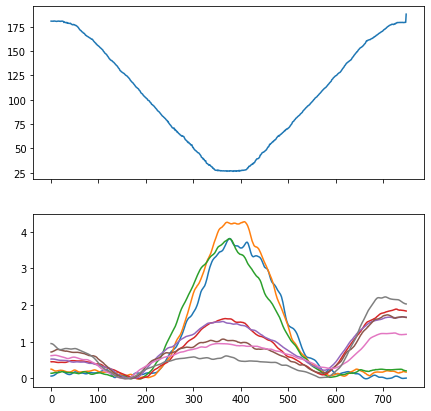

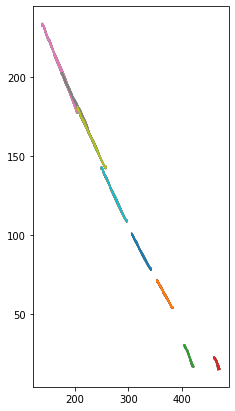

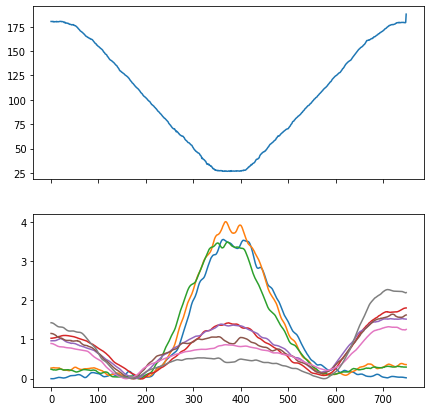

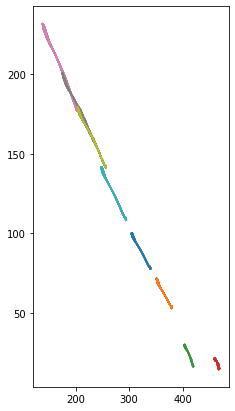

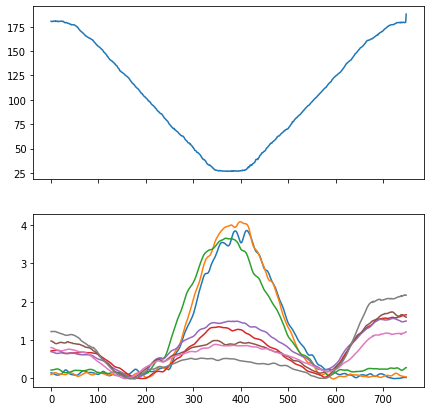

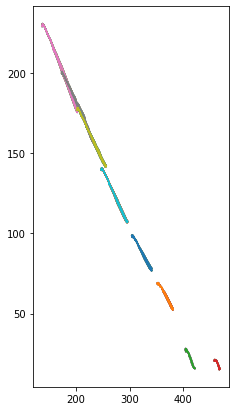

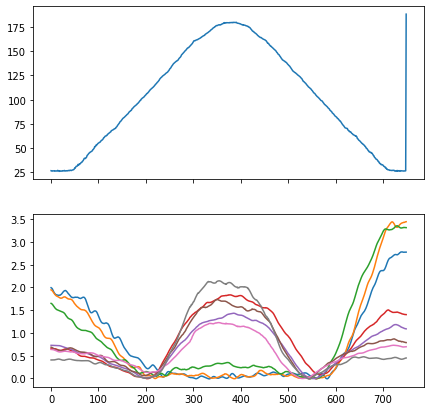

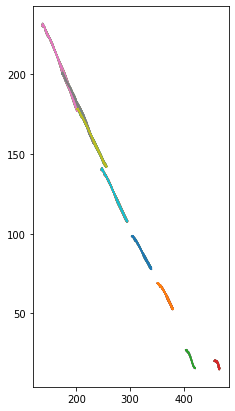

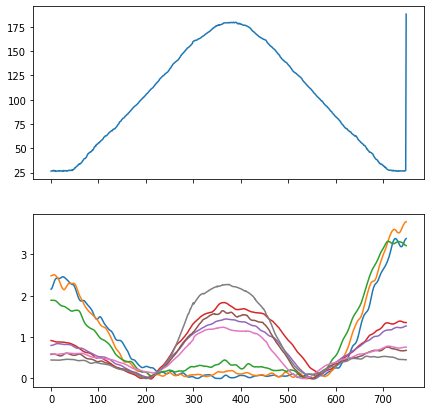

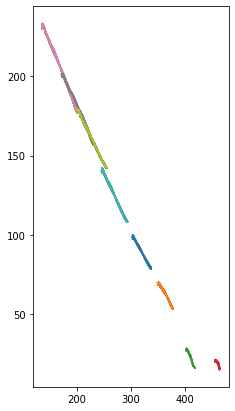

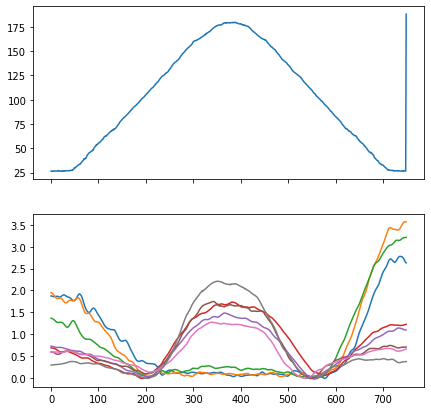

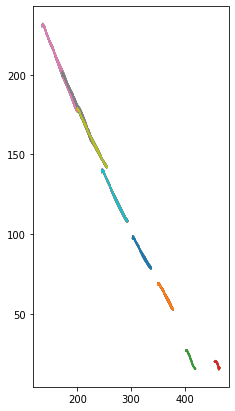

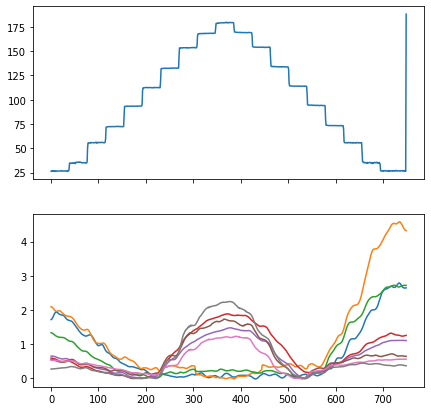

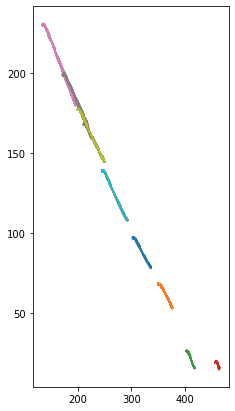

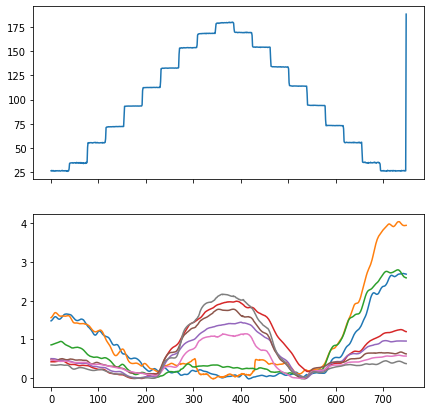

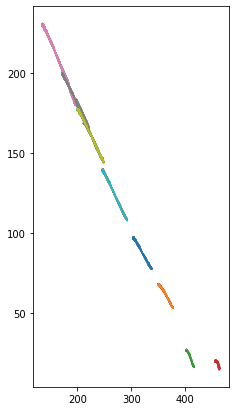

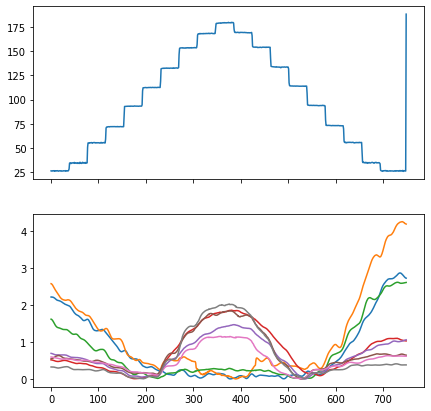

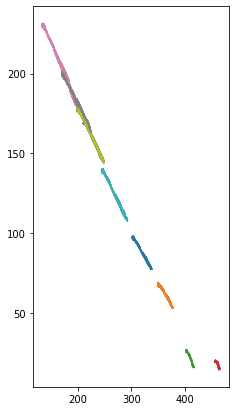

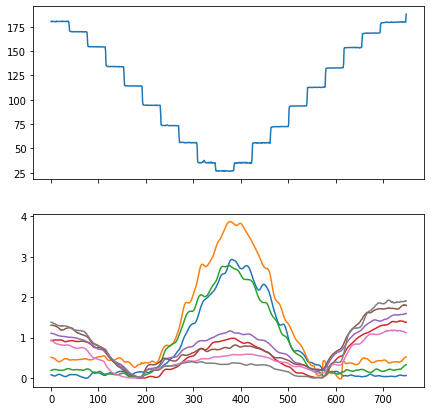

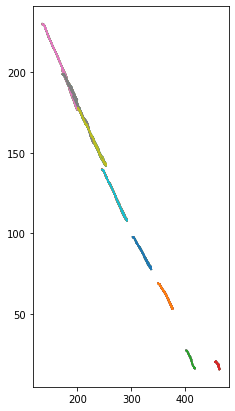

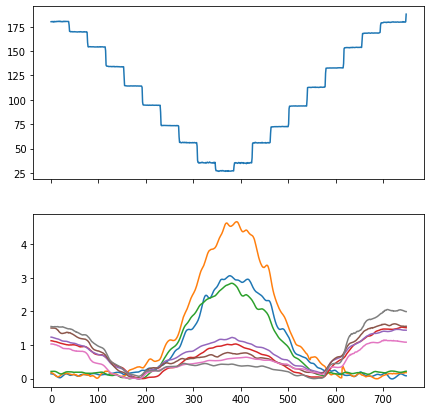

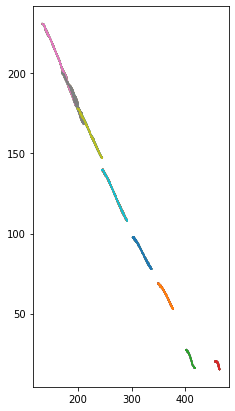

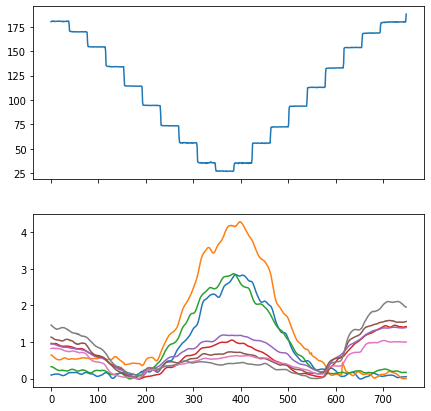

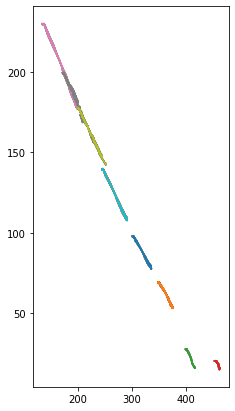

In [ ]:
calculate_tibia_angle_DRR_centroid_all_files(all_labels_files_path_sorted,
                                                        angles_file_path_sorted, tdTomato_files_path_sorted,
                                                        GCaMP_files_path_sorted)

### Summarize DRR and cell movements against the tibia angle

#### Get the path for all the directories corresponding to the 73D10 experiment.

* Currently only have data from one fly in the test directory.
* when we have all the data, set the directory path correctly.

In [ ]:
folder_path=[]
#Path for the image files
#NEED TO CHANGE THE PATH
path = '/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10'

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'20*'):
        folder_path.append(os.path.join(path,file_name))
        
folder_path_sorted=sorted(folder_path)

#Print to make sure
for f in folder_path_sorted:
    print(f)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200103-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200103-2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200103-3
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200103-4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200104-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200104-2


### Run for the trial type 2: Slow swing from the extension

In [ ]:
all_collected_data=collect_data_for_all_flies_from_extended(2,10,-10,3.5,54.5,folder_path_sorted,1,12.54)


/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/TrialID.xlsx
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00001tdTomato_Filtered_labels_all_merged_centroid_DRR_angle
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102T180044_20200102-3-73D10-tdt-7F_00001frame_dataframe_rate
64
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00001tdTomato_Filtered_labels_all_merged
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00002tdTomato_Filtered_labels_all_merged_centroid_DRR_angle
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102T180201_20200102-3-73D10-tdt-7F_00002frame_dataframe_rate
63
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00002tdTomato_Filtered_la

### Normalize DRR, plot all the data, save data

* currently don't have all the data in the test directory.
* the following line should give the same output as the plots shown below.

In [ ]:
outfile_name=(path+"/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type2")
norm_DRR_plot_save_data(all_collected_data, outfile_name)

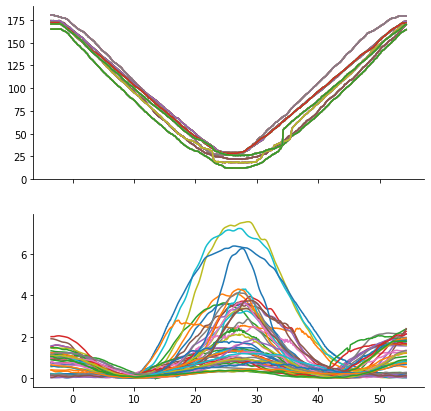

In [ ]:
#Plot all the tibia angles and the DRR
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
ax[0].set_ylim([0, 190])
ax[1].plot(time_axis,all_DRR_data)
sb.despine(fig=fig,ax=ax)

### This segment normalizes DRR and plots it against frame number.

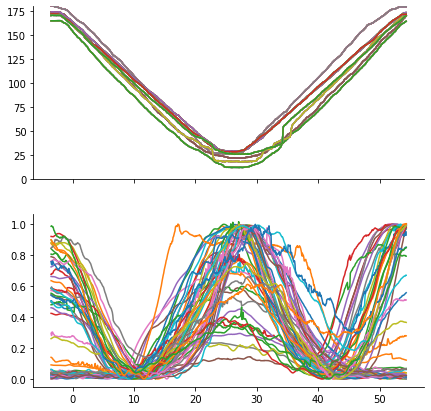

In [ ]:
#Normalize DRR
max_DRR=np.nanmax(all_DRR_data, axis=0)
min_DRR=np.nanmin(all_DRR_data, axis=0)

#Normalize DRR
norm_DRR=(all_DRR_data-min_DRR)/max_DRR

#Plot the tibia angle at the top and then DR_R at the bottom (for all clusters)
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
ax[0].set_ylim([0, 180])
ax[1].plot(time_axis,norm_DRR)
sb.despine(fig=fig,ax=ax)

### Run for the trial type 3: Slow swing from the flexed side (will detect motion from the extended side now).

In [ ]:

all_collected_data2=collect_data_for_all_flies_from_flexed(3,10,-10,32,25.5,folder_path_sorted,1,12.54)


/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/TrialID.xlsx
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00004tdTomato_Filtered_labels_all_merged_centroid_DRR_angle
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102T180539_20200102-3-73D10-tdt-7F_00004frame_dataframe_rate
428
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00004tdTomato_Filtered_labels_all_merged
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00005tdTomato_Filtered_labels_all_merged_centroid_DRR_angle
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102T180654_20200102-3-73D10-tdt-7F_00005frame_dataframe_rate
428
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/20200102-3/Move/20200102-3-73D10-tdt-7F_00005tdTomato_Filtered_

### Normalize DRR, plot all the data, save data (for the trial from the extension side).

* currently don't have all the data in the test directory.
* the following line should give the same output as the plots shown below.

In [ ]:
outfile_name=(path+"/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type3")
norm_DRR_plot_save_data(all_collected_data2, outfile_name)

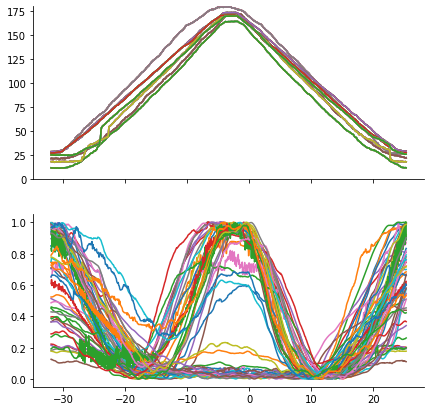

In [ ]:
#Normalize DRR
max_DRR=np.nanmax(all_DRR_data, axis=0)
min_DRR=np.nanmin(all_DRR_data, axis=0)

#Normalize DRR
norm_DRR=(all_DRR_data-min_DRR)/max_DRR

#Plot the tibia angle at the top and then DR_R at the bottom (for all clusters)
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
ax[0].set_ylim([0, 180])
ax[1].plot(time_axis,norm_DRR)
sb.despine(fig=fig,ax=ax)

### Rotate the prep to align all prep

#### Load the results from the previous analysis: Trial type 2 is for the slow swing from the extended side. Now we have time_axis.

* currently we don't have all the data on the test directory.
* following should produce the same plot as below.

In [ ]:
infile_name='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type2'
summary_data = load_summary_data(infile_name)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type2


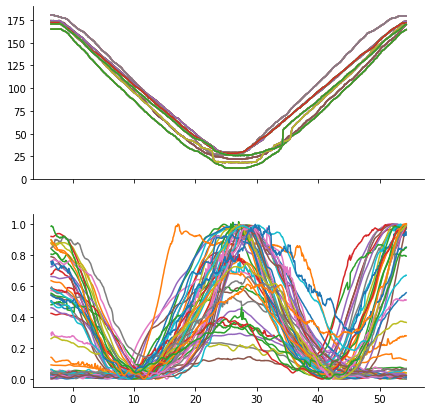

In [ ]:
#Read in and try plotting.
infile_name='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type2'
print(infile_name)
infile=open(infile_name,'rb')
[all_cell_centroid_column_data, all_cell_centroid_row_data, all_DRR_data, norm_DRR, all_cell_femur_tibia_angle_data, all_cell_fly_id_data, time_axis] = pickle.load(infile)
infile.close()
#Plot all the tibia angles and the normalized DRR
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
ax[0].set_ylim([0, 190])
ax[1].plot(time_axis,norm_DRR)
sb.despine(fig=fig,ax=ax)

#### Take the centroid coordinates for each prep and calculate the claw angle.

In [ ]:
claw_angle=get_claw_angle(summary_data['all_cell_centroid_column_data'],summary_data['all_cell_centroid_row_data'],summary_data['all_cell_fly_id_data'])

#### Apply rotation to the centroid values from before.
* The centroid values are already flipped for the row and also normalized so it should be fine to rotate around the origin. We need to flip the sign for the rotation_rad because the offset is in CCW direction.

In [ ]:
rotated_centroids=rotate_centroids(summary_data['all_cell_centroid_column_data'],
                                   summary_data['all_cell_centroid_row_data'],
                                   summary_data['all_cell_fly_id_data'], -(claw_angle))

#### Save the rotated values together with the previous values in a pickle file. Now we have time_axis.

In [ ]:
path='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10'
outfile_name=(path+"/all_cell_centroids_column_row_rotated_DRR_normDRR_angle_flyId_trial_type2")
save_rotated_data(outfile_name, summary_data, rotated_centroids)

### Make new plot for those that involve centroid position. Using values before and after the rotation

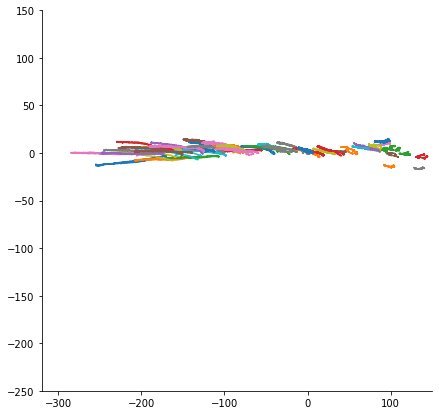

In [ ]:
#Plot rotated centroid row against column
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(7,7))
ax.plot(all_cell_centroid_column_data_rotated,all_cell_centroid_row_data_rotated)
ax.set_ylim([-250,150])
ax.set_xlim([-320,150])
sb.despine(fig=fig,ax=ax)

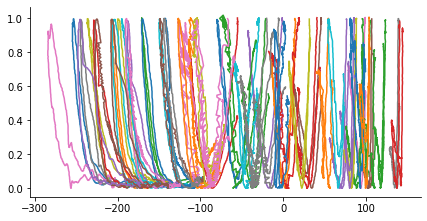

In [ ]:
#Plot norm DRR agaist the rotated centroid column
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(7,3.5))
ax.plot(all_cell_centroid_column_data_rotated,norm_DRR)
#ax[0].set_ylim([0, 190])
#ax[1].plot(norm_DRR)
sb.despine(fig=fig,ax=ax)

#### Load the results from the previous analysis: Trial type 3 is for the slow swing from the extended side. Now we also have time_axis.

In [ ]:
infile_name='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type3'
summary_data = load_summary_data(infile_name)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type3


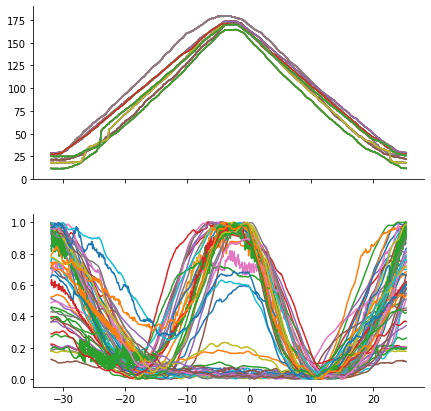

In [ ]:
#Read in and try plotting.
infile_name='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10/all_cell_centroids_column_row_DRR_normDRR_angle_trial_type3'
print(infile_name)
infile=open(infile_name,'rb')
[all_cell_centroid_column_data, all_cell_centroid_row_data, all_DRR_data, norm_DRR, all_cell_femur_tibia_angle_data, all_cell_fly_id_data, time_axis] = pickle.load(infile)
infile.close()
#Plot all the tibia angles and the normalized DRR
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row',figsize=(7,7))
ax[0].plot(time_axis,all_cell_femur_tibia_angle_data)
ax[0].set_ylim([0, 190])
ax[1].plot(time_axis,norm_DRR)
sb.despine(fig=fig,ax=ax)

#### Get the claw angles for each prep using these trials. May change with trials so re-calculate.

In [ ]:
claw_angle=get_claw_angle(summary_data['all_cell_centroid_column_data'],summary_data['all_cell_centroid_row_data'],summary_data['all_cell_fly_id_data'])

#### Apply rotation to the centroid values from before.
* The centroid values are already flipped for the row and also normalized so it should be fine to rotate around the origin. We need to flip the sign for the rotation_rad because the offset is in CCW direction.

In [ ]:
rotated_centroids=rotate_centroids(summary_data['all_cell_centroid_column_data'],
                                   summary_data['all_cell_centroid_row_data'],
                                   summary_data['all_cell_fly_id_data'], -(claw_angle))

#### Save the rotated values together with the previous values in a pickle file. Now we have time_axis.

In [ ]:
path='/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10'
outfile_name=(path+"/all_cell_centroids_column_row_rotated_DRR_normDRR_angle_flyId_trial_type3")
save_rotated_data(outfile_name, summary_data, rotated_centroids)

### Make new plot for those that involve centroid position. Using values before and after the rotation

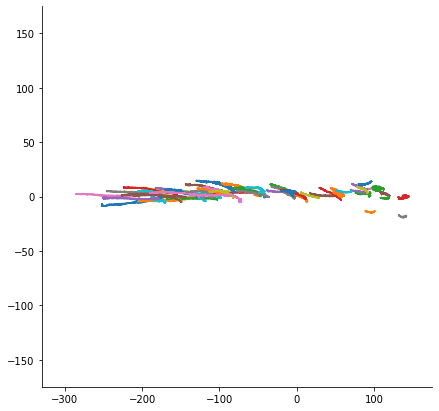

In [ ]:
#Plot rotated centroid row against column
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(7,7))
ax.plot(all_cell_centroid_column_data_rotated,all_cell_centroid_row_data_rotated)
ax.set_ylim([-175,175])
ax.set_xlim([-330,175])
sb.despine(fig=fig,ax=ax)

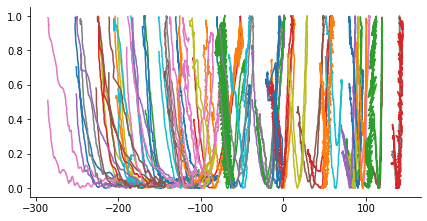

In [ ]:
#Plot norm DRR agaist the rotated centroid column
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(7,3.5))
ax.plot(all_cell_centroid_column_data_rotated,norm_DRR)
#ax[0].set_ylim([0, 190])
#ax[1].plot(norm_DRR)
sb.despine(fig=fig,ax=ax)